In [3]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

# Computing the sine transform using the FFT

The sine transform should be an approximation of 

$$
b_k = \sqrt{2}\int_{0}^1 f(x)\sin(k\pi x)dx %= \frac{\sqrt{2}}{\pi}\int_{0}^\pi f\Big(\frac{y}{\pi}\Big)\sin(ky)dy
$$


 Define 
\begin{aligned}
\tilde{f} = \begin{cases}f(2x) \quad &0\leq x  \leq 1/2 \\
-f(2(1-x)) \quad & 1/2\leq x\leq 1 \end{cases}
\end{aligned}


Then 
\begin{aligned}
\int_{0}^{1} \tilde{f}(y)\exp(2k\pi i y)dy  &= \int_{0}^{1/2} \tilde{f}(y)\exp(2k\pi i y)dy -  \int_{1/2}^{1}\tilde{f}(y)\exp(2k\pi i y)dy\\
&= \int_{0}^{1/2} f(2y)\exp(2k\pi i y)dy -  \int_{1/2}^{1}f(2(1- y))\exp(2k\pi i y)dy\\
&=  \int_{0}^{1/2}f(2y)\exp(2k\pi i y)dy -  \int_{1/2}^{0}f(2y)\exp(2k\pi i (1-y))dy \\
&=  \int_{0}^{1/2} f(2y)\exp(2k\pi i y)dy +  \int_{0}^{1/2}f(2y)\exp(2k\pi i (1-y))dy \\
&=  \int_{0}^{1/2} f(2y)\exp(2k\pi i y)dy +  \int_{0}^{1/2}f(2y)\exp(-2k\pi iy)dy \\
&=  \int_{0}^{1/2} (f(2y)\exp(2k\pi i y)-\exp(-2k\pi iy)) dy \\
&=  2i\int_{0}^{1/2} f(2y)\sin(2k\pi y)  dy \\
&= i\int_{0}^{1} f(y)\sin(k\pi y)  dy 
\end{aligned}

Hence the sine transform can be found by extending the function in the above manner and computing the DFT which computes $\int_{0}^{1} \tilde{f}(y)\exp(-2k\pi i y)dy\approx \frac{1}{N}\alpha_k$ . Hence
$$
b_k =\frac{\sqrt{2}}{i}\int_{0}^{1} \tilde{f}(y)\exp(2k\pi i y)dy \approx -\frac{1}{\sqrt{2}Ni}\alpha_k
$$

In [4]:
domain = jnp.array([0,1])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
k,l = 4, 9
f = lambda x: 3.45*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x) - 0.76*jnp.sqrt(2)*jnp.sin(jnp.pi*l*x)

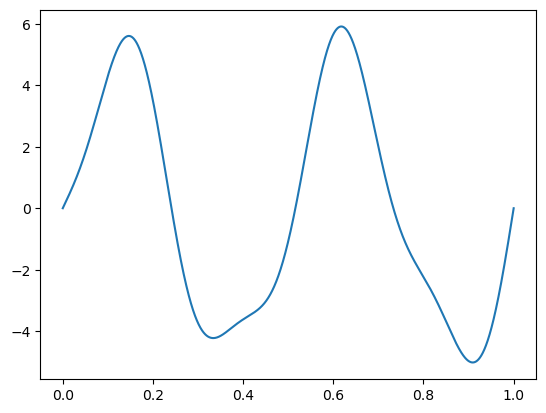

In [6]:
n_points = 2**12
grid = jnp.linspace(domain[0], domain[1], n_points)
y_values = f(grid)
plt.plot(grid, y_values)

In [7]:
def discrete_sine_transform(y):
    n = y.shape[0] +1
    y_extended = jnp.concatenate([y, jnp.array([0]), -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1]

In [8]:
dst = discrete_sine_transform(y_values)
dst[0], dst[k], dst[l]

(Array(-0., dtype=float64),
 Array(3.44904185, dtype=float64),
 Array(-0.75929242, dtype=float64))

In [9]:
test = discrete_sine_transform(discrete_sine_transform(y_values))

In [10]:
n_points, y_values.shape

(4096, (4096,))

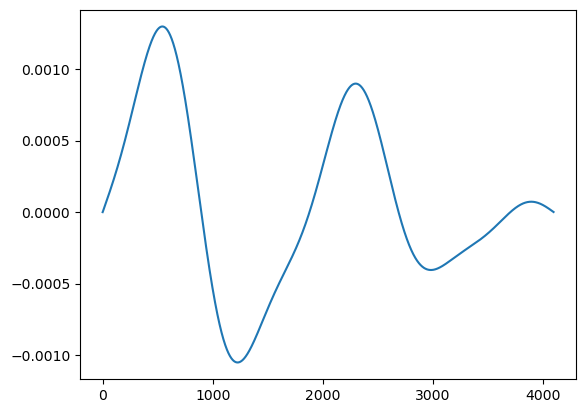

In [11]:
plt.plot(test)

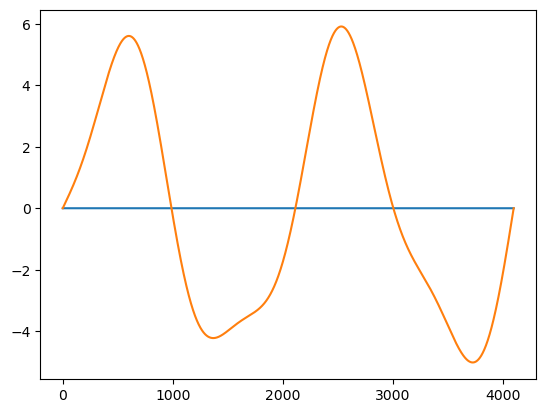

In [12]:
plt.plot(test/n_points*2)
plt.plot(y_values)

In [13]:
test.shape, y_values.shape

((4096,), (4096,))

# Computing the discrete sine transform for a kernel

We wish to compute the discrete sine transform:
$$
\int_{0}^1 \int_{0}^{1} \sin(l\pi i x )k(x,y)\sin(k\pi i y)  dy 
$$

This can be done by applying the DST twice. 

In [14]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y
b =lambda x : jnp.ones_like(x)*1.0
length_scale = 1.0
upper = jnp.array([1.0])
lower = jnp.array([0.0])
boundary = jnp.hstack([lower, upper])
nu = 0.1

In [15]:
n_meas = 1000
domain = jnp.linspace(0,1,n_meas+1) # We add a point because we do not want the constant
#theta_22 = vmap_kernel(domain, domain, length_scale)
theta_22 = vmap_L_b_xy(domain, domain, length_scale,nu, b(domain), b(domain))


In [16]:
vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
theta_22_sine = vmap_dst(vmap_dst(theta_22).T)

In [17]:
jnp.linalg.eigh(theta_22)[0][0] # The matrix is PSD (sanity check)

Array(0.00074536, dtype=float64)

In [18]:
# Computing the transform by hand

k, l = 4, 10
G = theta_22*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*domain), jnp.sqrt(2)*jnp.sin(jnp.pi*l*domain))
integrate.trapezoid(integrate.trapezoid(G, domain), domain)


0.011739675660023367

In [19]:
theta_22_sine[k,l]

Array(0.01173725, dtype=float64)

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}


In [20]:
key = random.PRNGKey(635)
nu = 0.01
n_coef = 5000
frequencies = jnp.arange(1, n_coef+1)
coef_f = random.normal(key, shape= (n_coef,))
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

In [21]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    frequencies = jnp.arange(1, c.shape[0]+1)
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [22]:
f_values = evaluate_basis_sine(domain, coef_f)
u_values = evaluate_basis_sine(domain, coef_u)

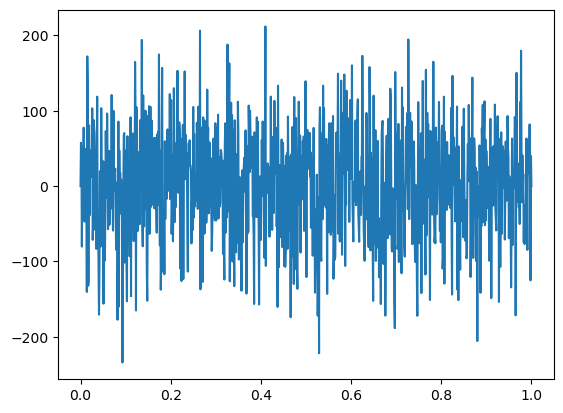

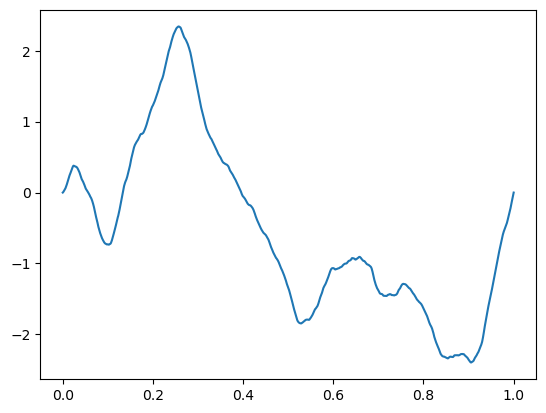

In [23]:
plt.figure()
plt.plot(domain, f_values)

plt.figure()
plt.plot(domain, u_values)

In [24]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y, vmap_kernel

In [25]:
n_meas = 5000
domain_measurements = jnp.linspace(0,1, n_meas+1)

In [26]:
length_scale = 1.0
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))


In [27]:
theta_22_sine = vmap_dst(vmap_dst(theta_22).T)[1:, 1:]
theta_12_sine = vmap_dst(theta_12)[:, 1:]

In [28]:
theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

In [29]:
jnp.linalg.eigh(theta)[0][0] # The matrix is PSD (sanity check)

Array(6.22886908e-17, dtype=float64)

In [30]:
rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])

In [31]:
nugget = jnp.concatenate([jnp.zeros_like(boundary), 1e-8*jnp.ones(n_meas)])

In [32]:
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos")

In [33]:
K = vmap_kernel(domain_measurements, boundary, length_scale)
K_interior = vmap_dst(vmap_L_b_y(domain_measurements, domain_measurements, length_scale, nu, b(domain_measurements)))[:, 1:]
K_eval = jnp.block([K, K_interior])

In [34]:
K.shape, K_interior.shape, K_eval.shape, alpha.shape

((5001, 2), (5001, 5000), (5001, 5002), (5002,))

In [35]:
pred = K_eval@alpha

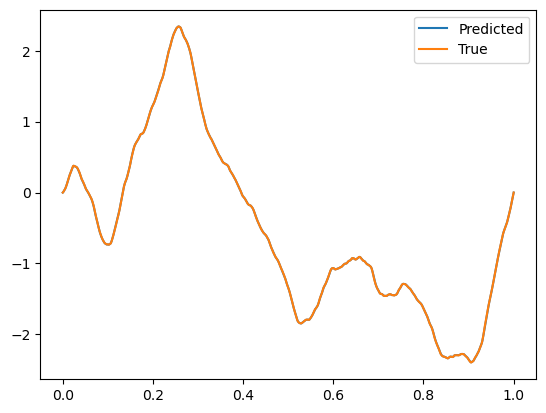

In [36]:
plt.plot(domain_measurements, pred, label = "Predicted")
plt.plot(domain, u_values, label = "True")
plt.legend()

# Computing error rates

In [37]:
pred_transform = discrete_sine_transform(pred)[1:]
jnp.linalg.norm(pred_transform - coef_u[:n_meas])/jnp.linalg.norm(coef_u[:n_meas])

Array(0.00108541, dtype=float64)

In [38]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    frequencies = jnp.arange(1, c.shape[0]+1)
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [39]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [40]:
key = random.PRNGKey(635)
nu = 0.01
n_coef = 2**14
domain_finest = jnp.linspace(0,1,n_coef+1)
print(n_coef)
n_meas = 2**10
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)


frequencies = jnp.arange(1, n_coef+1)
coef_f = random.normal(key, shape= (n_coef,))
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

16384
1024


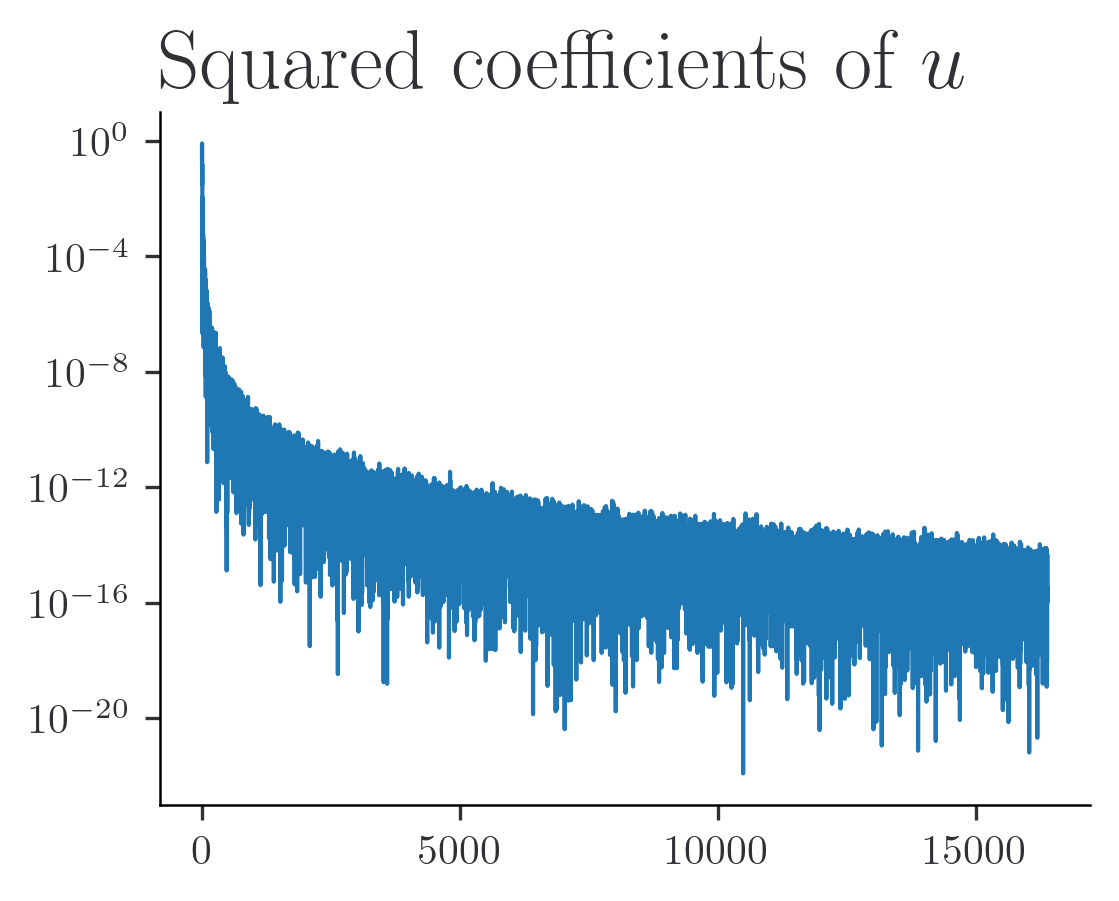

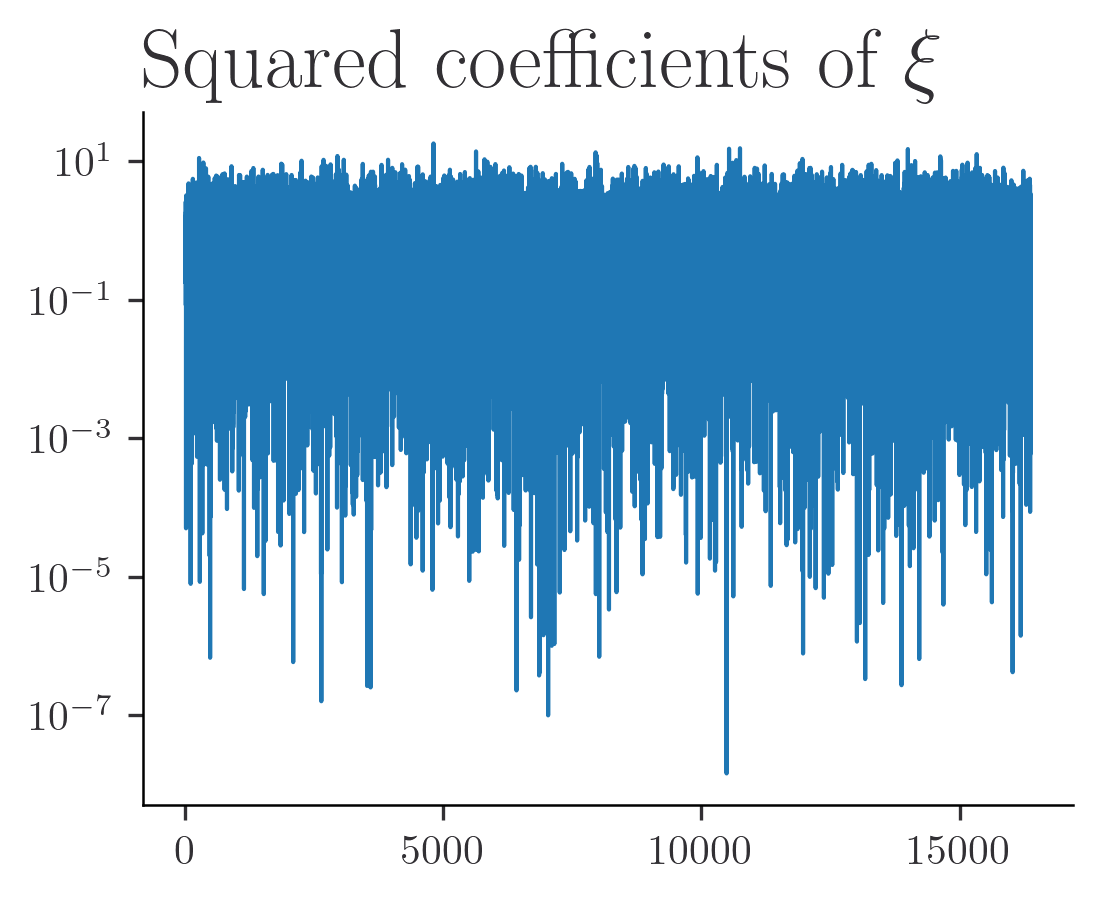

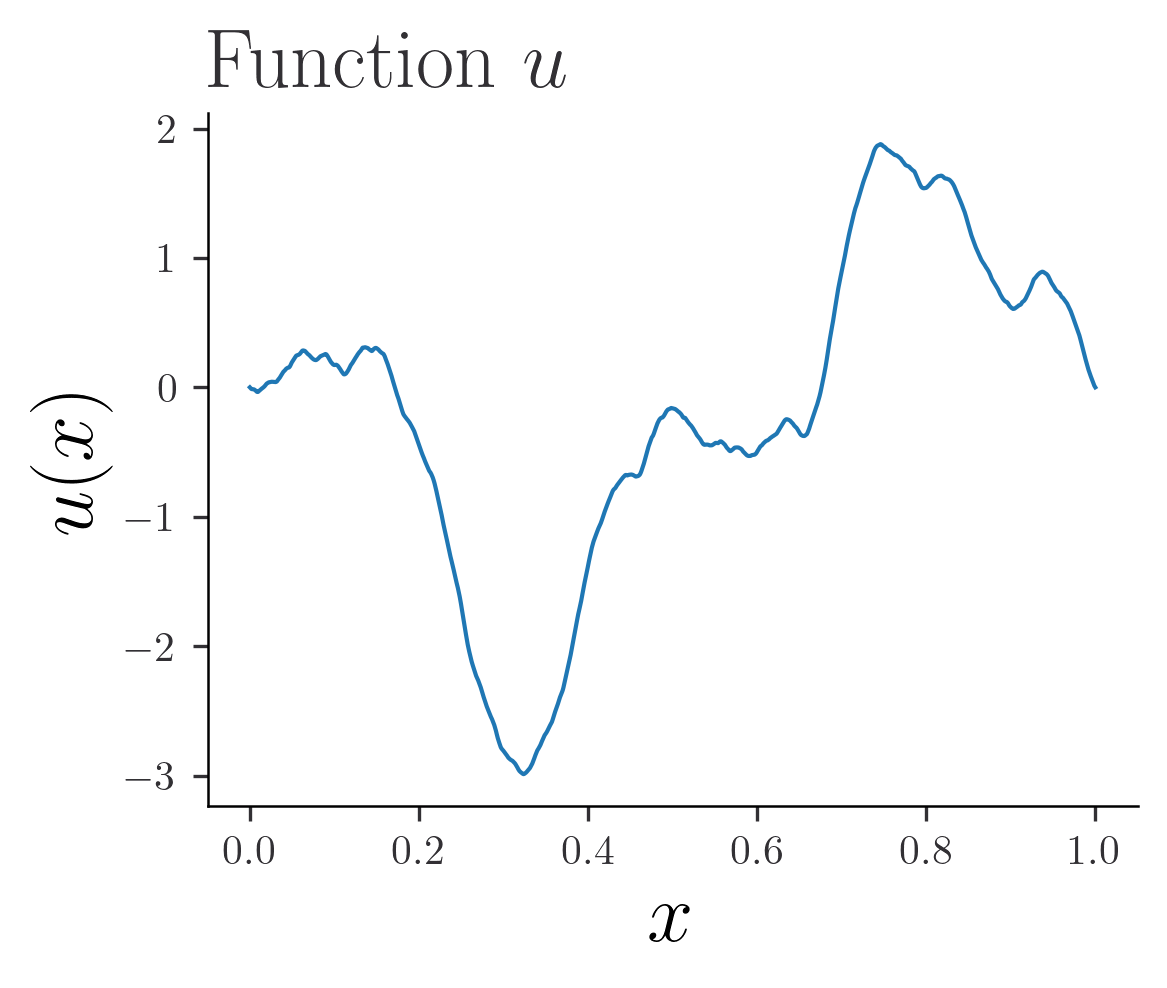

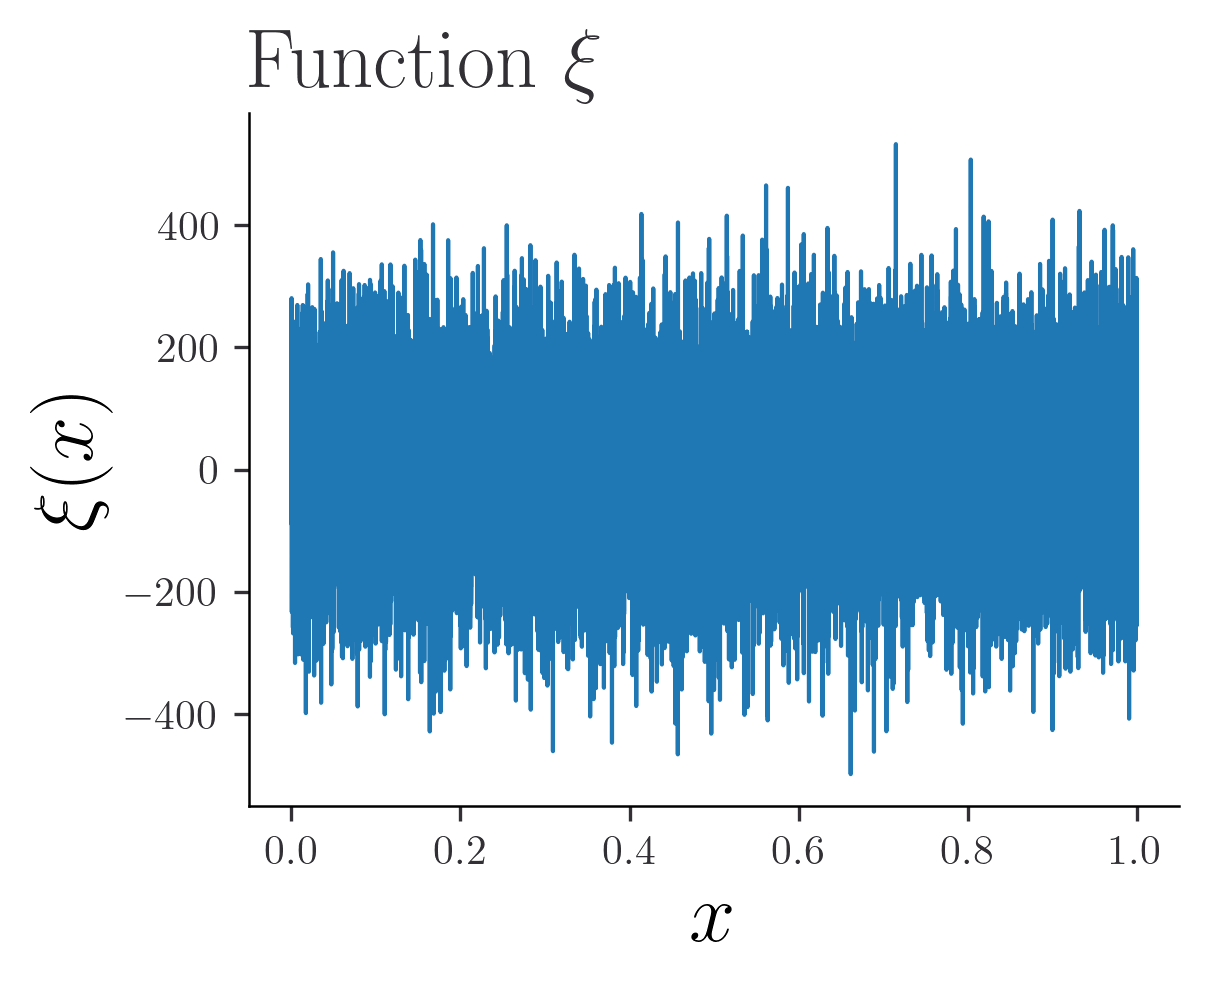

In [41]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [42]:
n_meas = 2**10
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
length_scale = 0.5
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

theta_22_sine = vmap_dst(vmap_dst(theta_22).T)[1:, 1:]
theta_12_sine = vmap_dst(theta_12)[:, 1:]
theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

1024


In [43]:
rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])

nugget = jnp.concatenate([jnp.zeros_like(boundary), 1e-8*jnp.ones(n_meas)])
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

In [44]:
# Predict on the finest mesh
K = vmap_kernel(domain_finest, boundary, length_scale)
K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))[:, 1:]
K_eval = jnp.block([K, K_interior])
pred = K_eval@alpha

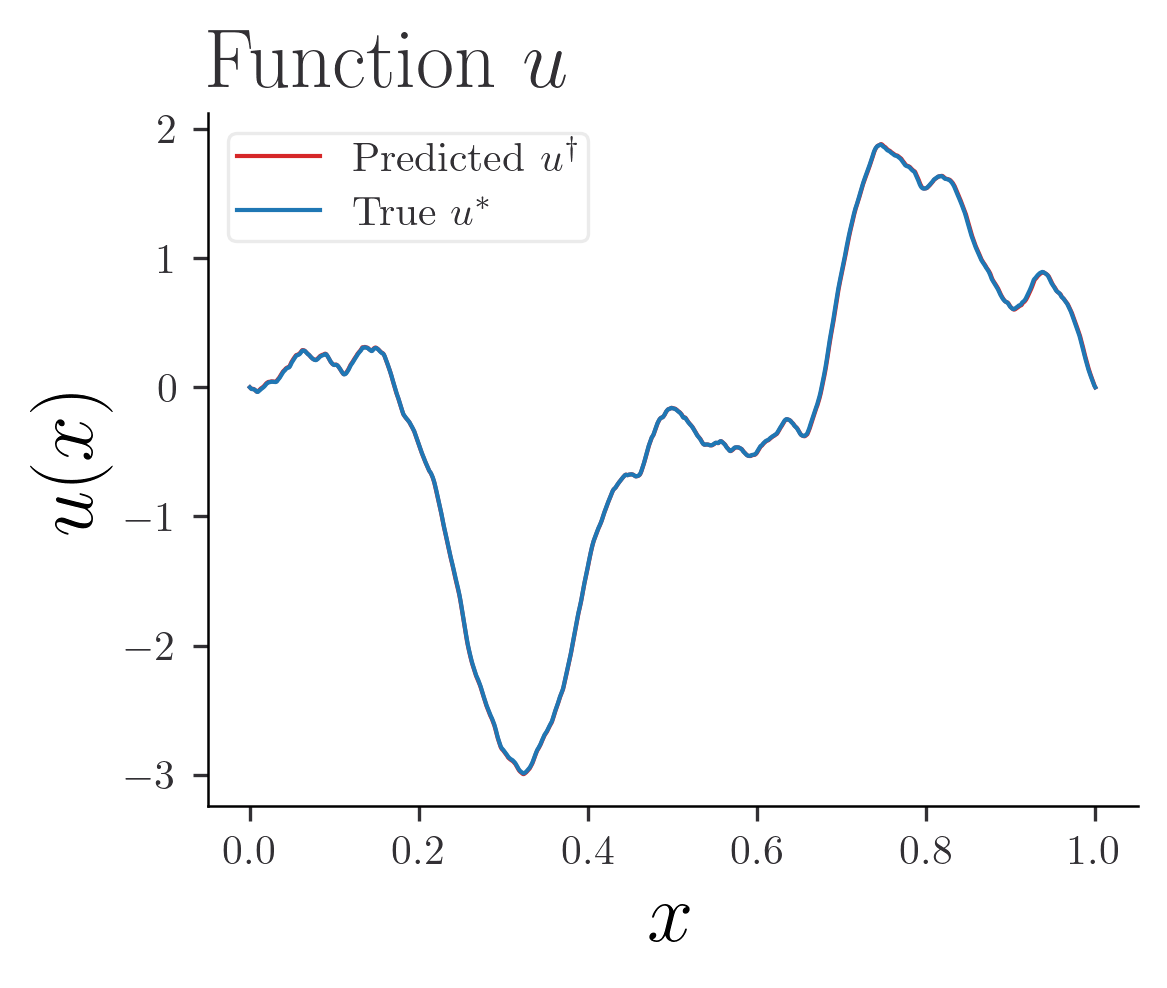

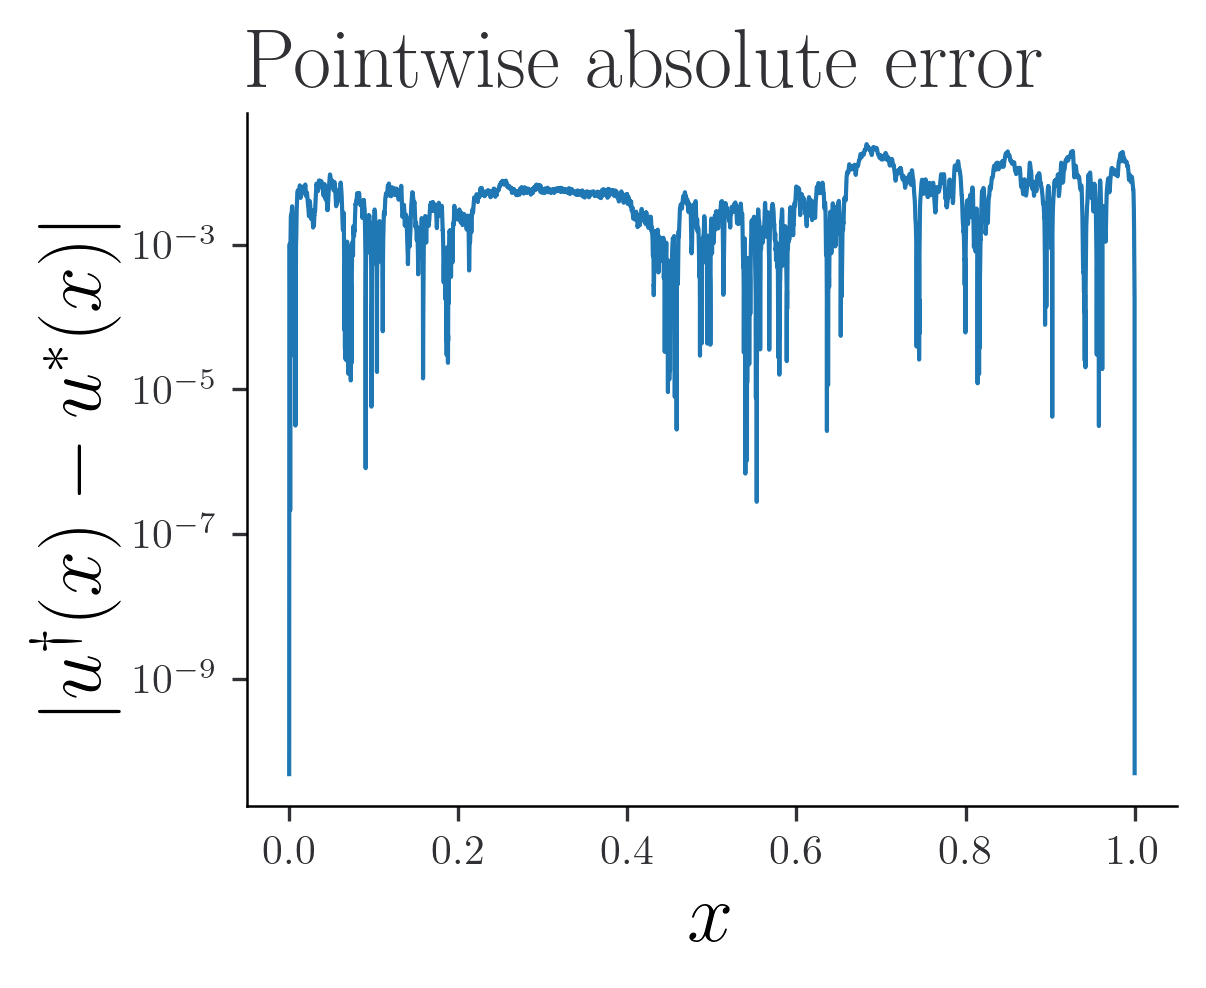

In [45]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()




In [46]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)



0.006488132858379549 0.0052135187279590866


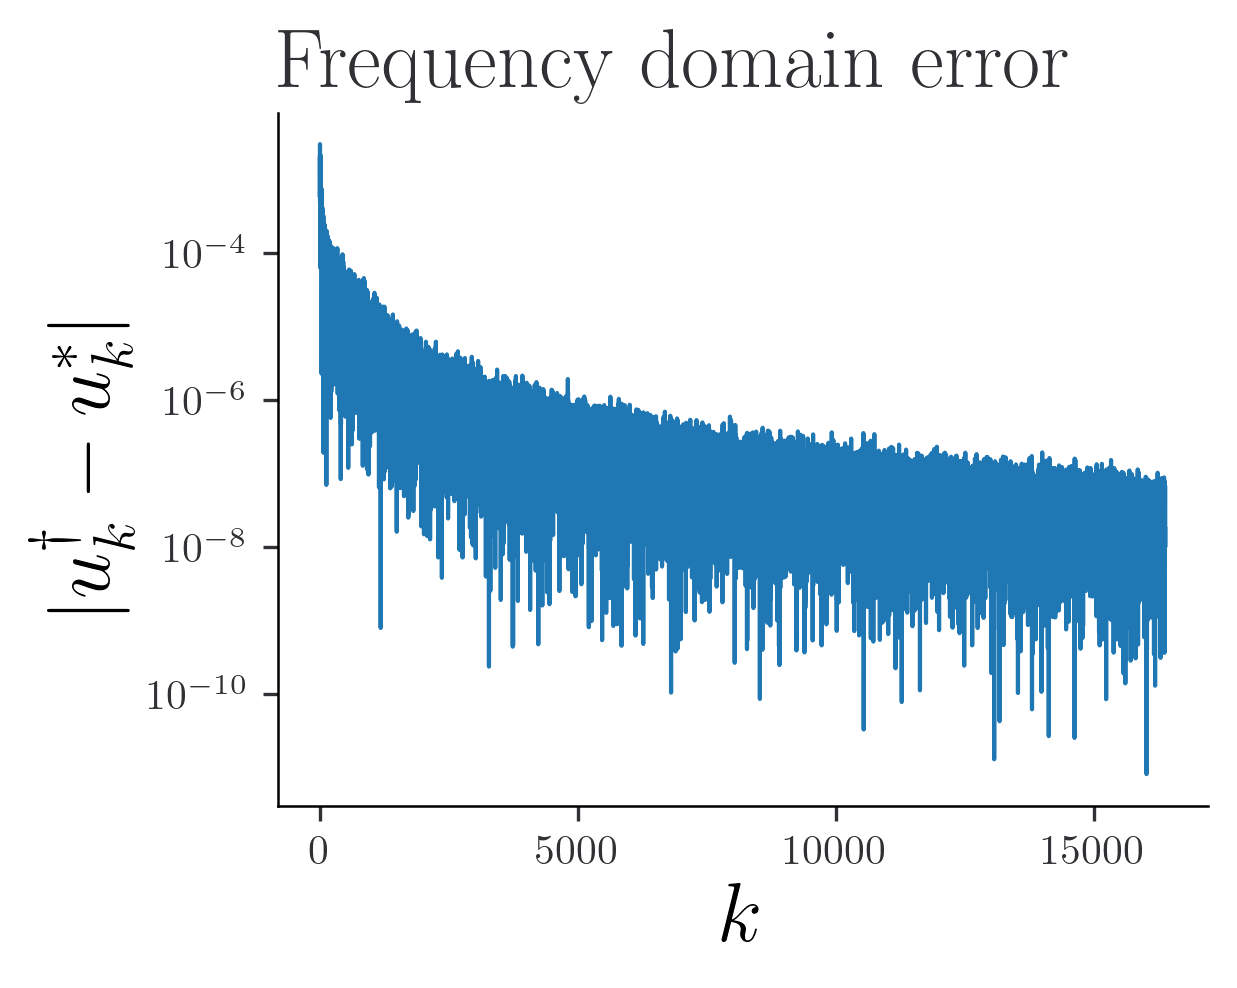

In [47]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq)
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

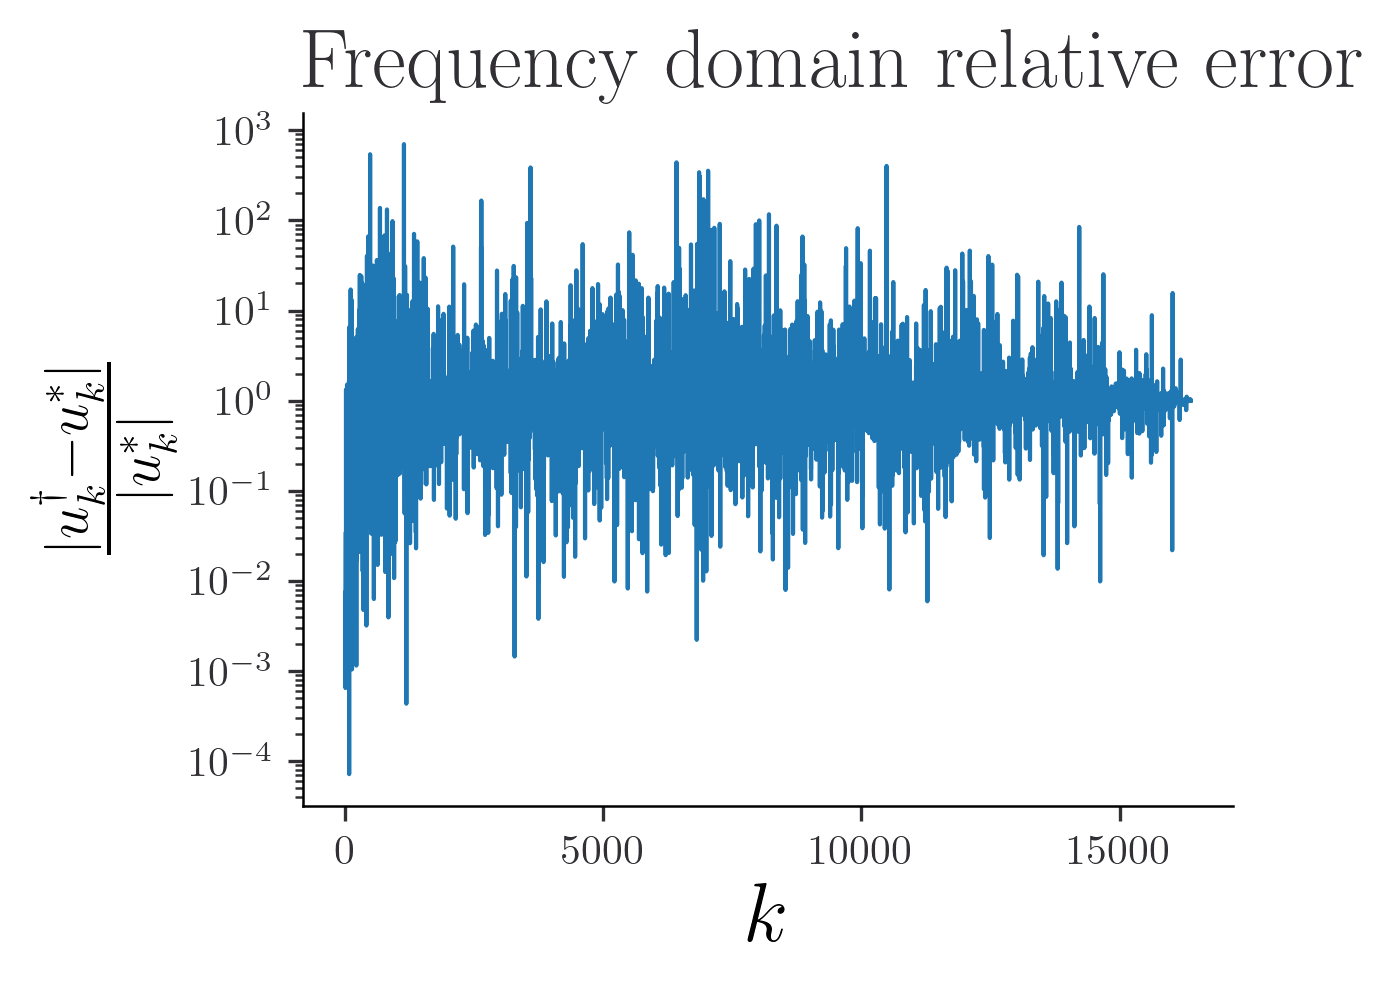

In [48]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel)
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

In [49]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-10


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)[1:, 1:]
    theta_12_sine = vmap_dst(theta_12)[:, 1:]
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    # Solve the linear system
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # 

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))[:, 1:]
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Compute errors
    pred_transform = discrete_sine_transform(pred)[1:]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
    error.append(L2_error)
    error_rel.append(relative_L2_error)
    
    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:04<00:37,  4.65s/it]

32


 22%|██▏       | 2/9 [00:09<00:31,  4.55s/it]

64


 33%|███▎      | 3/9 [00:13<00:27,  4.53s/it]

128


 44%|████▍     | 4/9 [00:18<00:23,  4.73s/it]

256


 56%|█████▌    | 5/9 [00:24<00:20,  5.21s/it]

512


 67%|██████▋   | 6/9 [00:31<00:17,  5.71s/it]

1024


 78%|███████▊  | 7/9 [00:33<00:08,  4.47s/it]

2048


 89%|████████▉ | 8/9 [00:48<00:07,  7.83s/it]

4096


100%|██████████| 9/9 [01:24<00:00,  9.42s/it]


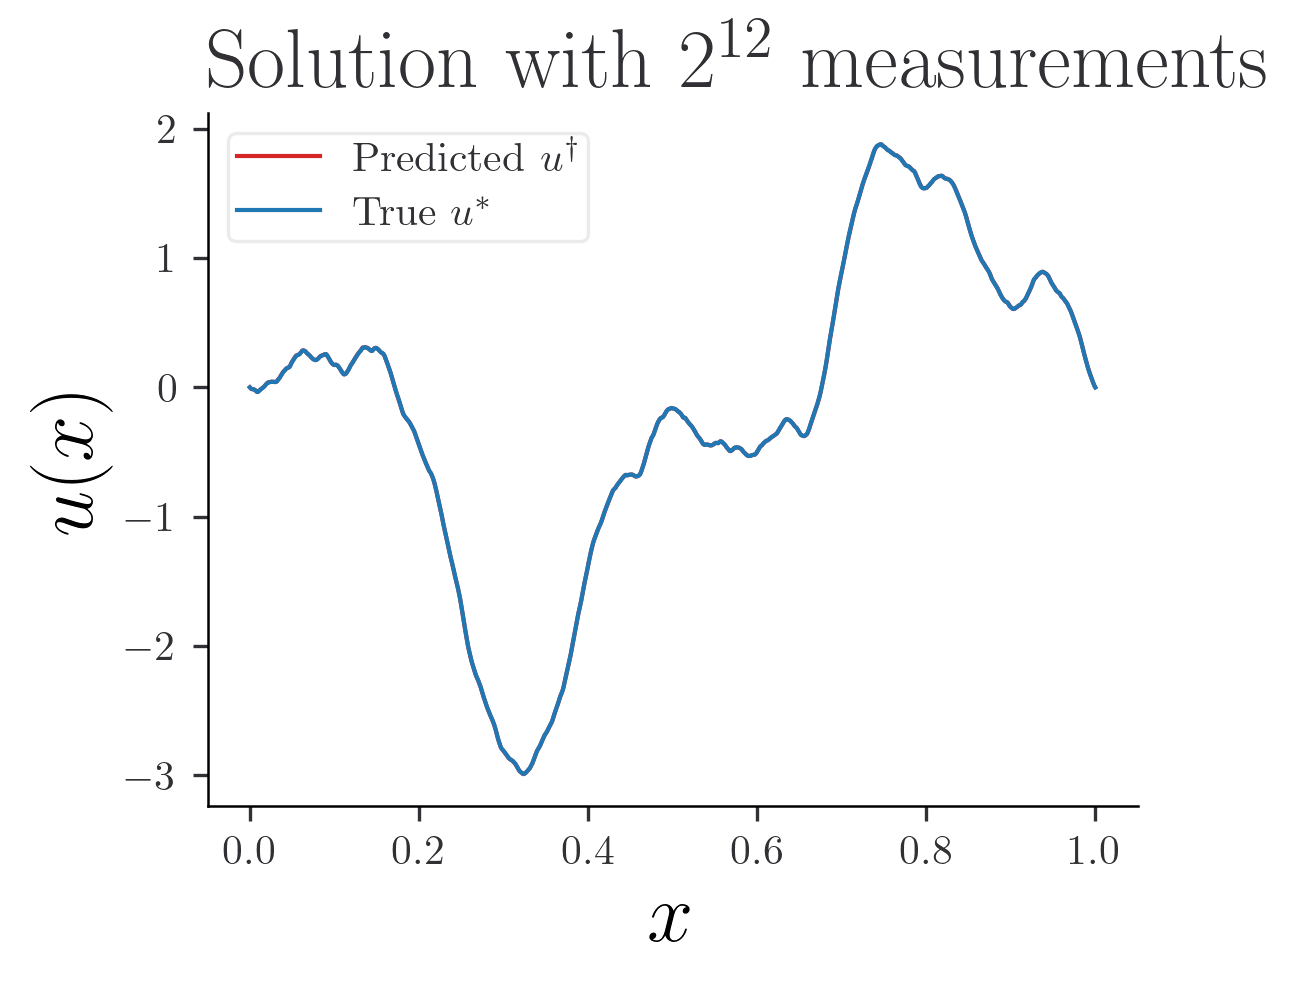

In [71]:
figure = plt.figure(figsize=(width, height))


plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


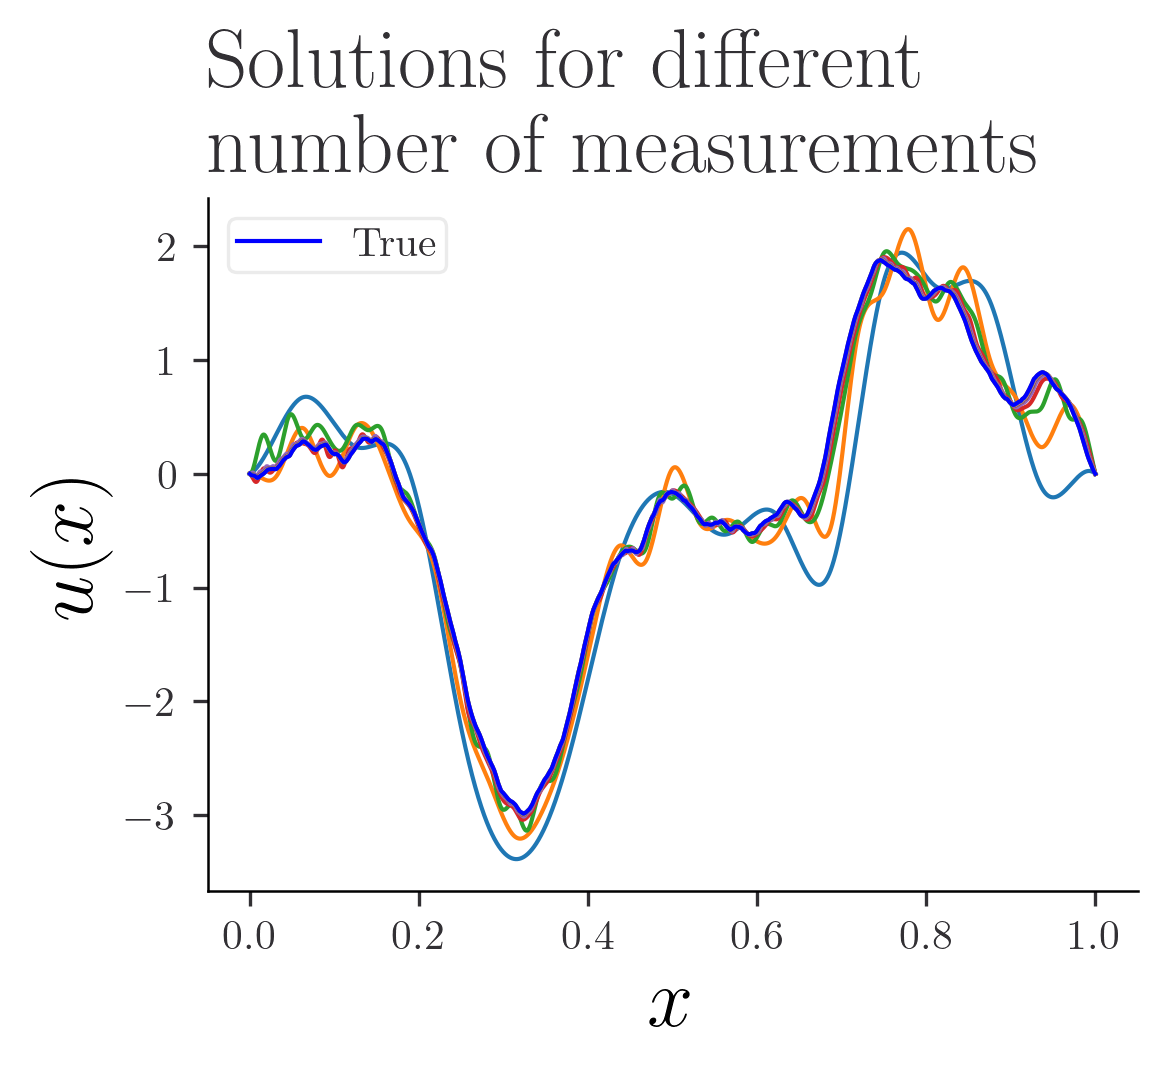

In [50]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [51]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.06


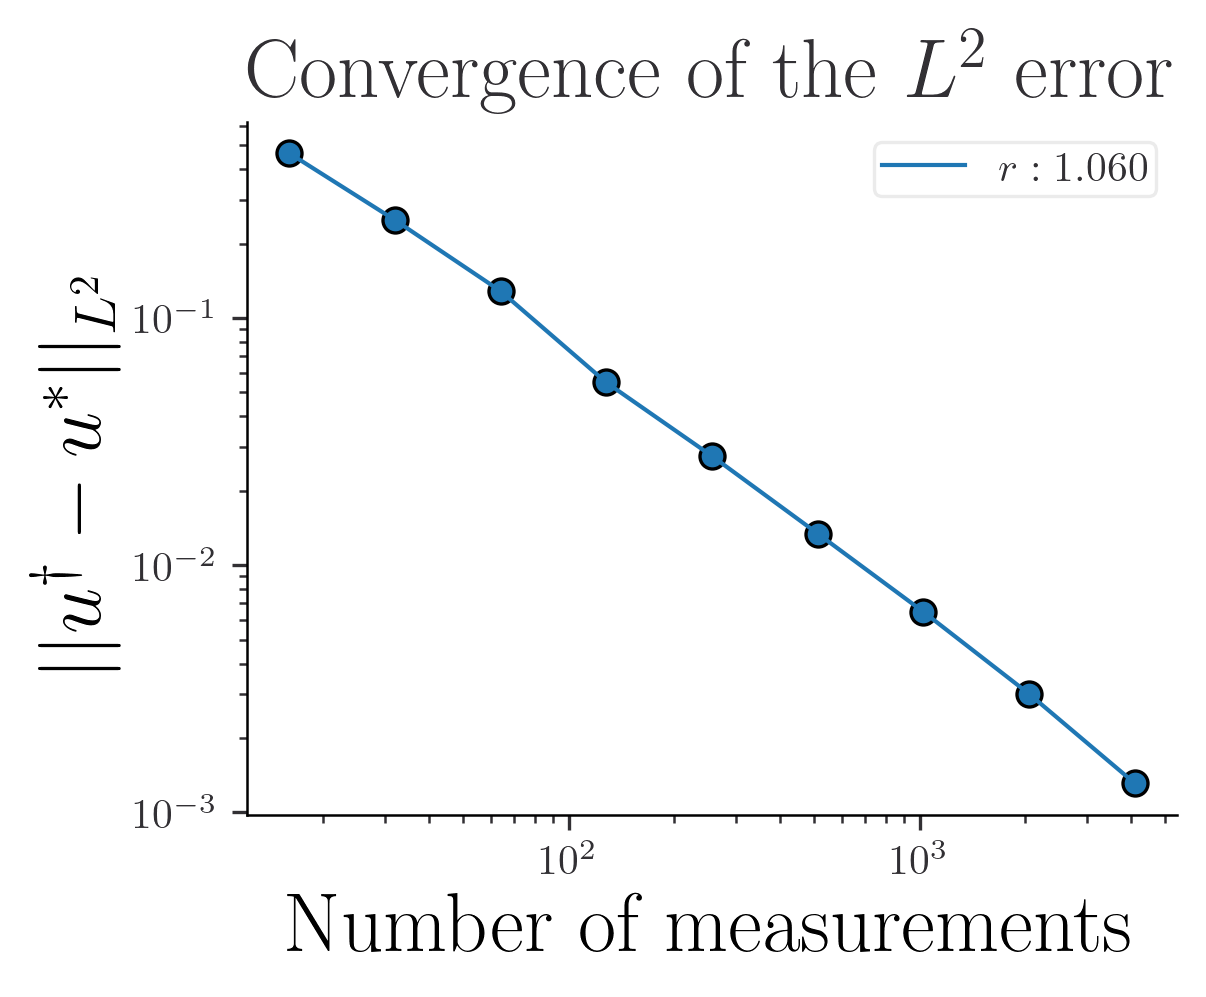

In [52]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


In [53]:
error[-1]

Array(0.00131235, dtype=float64)

In [58]:
error

Array([0.46452426, 0.24913641, 0.12849001, 0.05487231, 0.02764288,
       0.01342891, 0.00647958, 0.0030163 , 0.00131235], dtype=float64)

In [57]:
2**meas_exp

Array([  16,   32,   64,  128,  256,  512, 1024, 2048, 4096], dtype=int64)

In [59]:
meas_exp

Array([ 4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

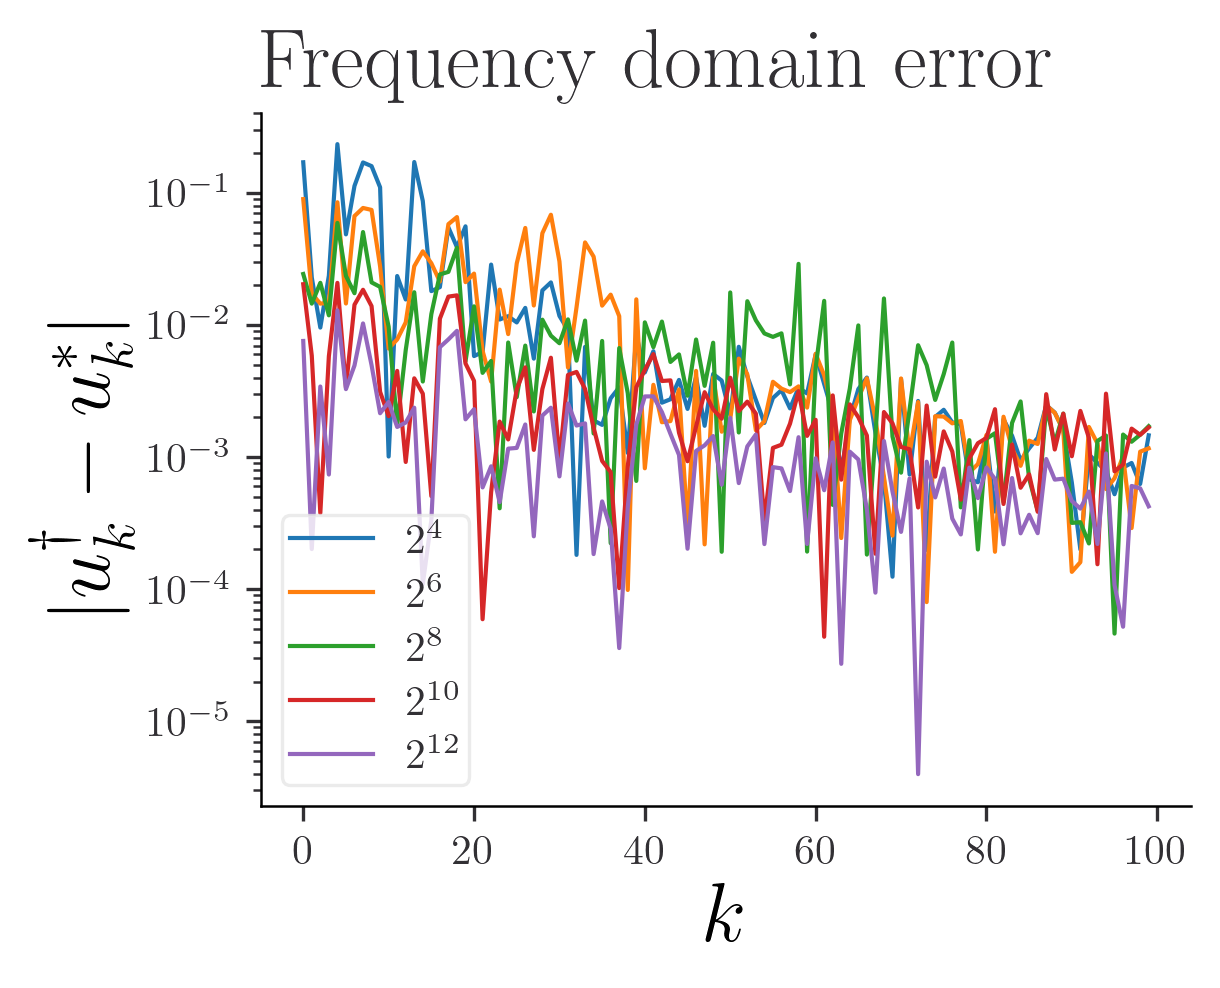

In [303]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


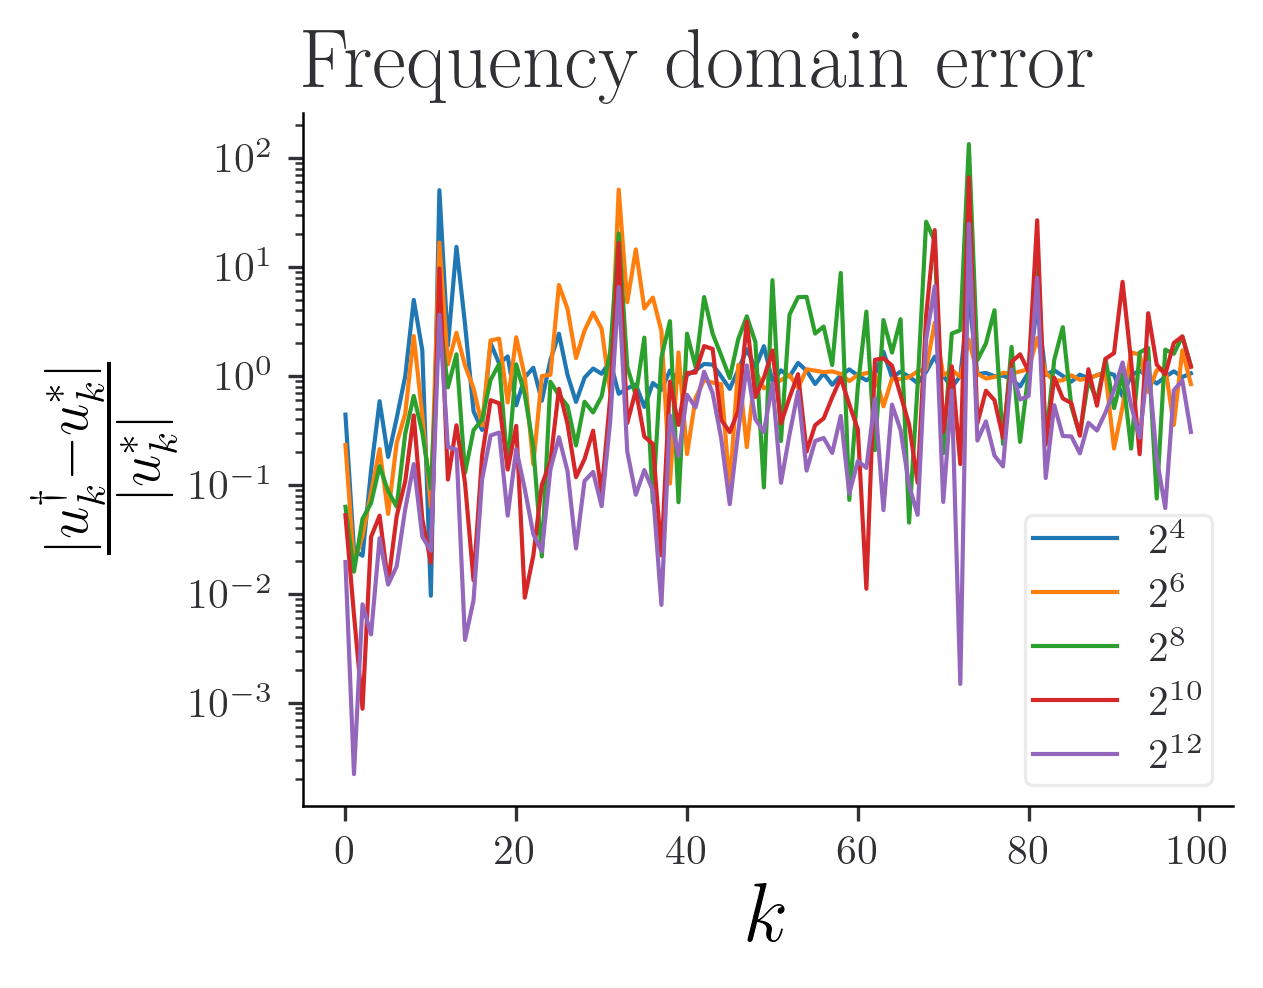

In [304]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Higher nugget

In [305]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-5


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)[1:, 1:]
    theta_12_sine = vmap_dst(theta_12)[:, 1:]
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    # Solve the linear system
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # 

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))[:, 1:]
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Compute errors
    pred_transform = discrete_sine_transform(pred)[1:]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
    error.append(L2_error)
    error_rel.append(relative_L2_error)
    
    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:05,  1.46it/s]

32


 22%|██▏       | 2/9 [00:01<00:04,  1.57it/s]

64


 33%|███▎      | 3/9 [00:01<00:03,  1.59it/s]

128


 44%|████▍     | 4/9 [00:02<00:03,  1.57it/s]

256


 56%|█████▌    | 5/9 [00:03<00:02,  1.47it/s]

512


 67%|██████▋   | 6/9 [00:04<00:02,  1.30it/s]

1024


 78%|███████▊  | 7/9 [00:06<00:02,  1.20s/it]

2048


 89%|████████▉ | 8/9 [00:15<00:03,  3.81s/it]

4096


100%|██████████| 9/9 [00:44<00:00,  4.91s/it]


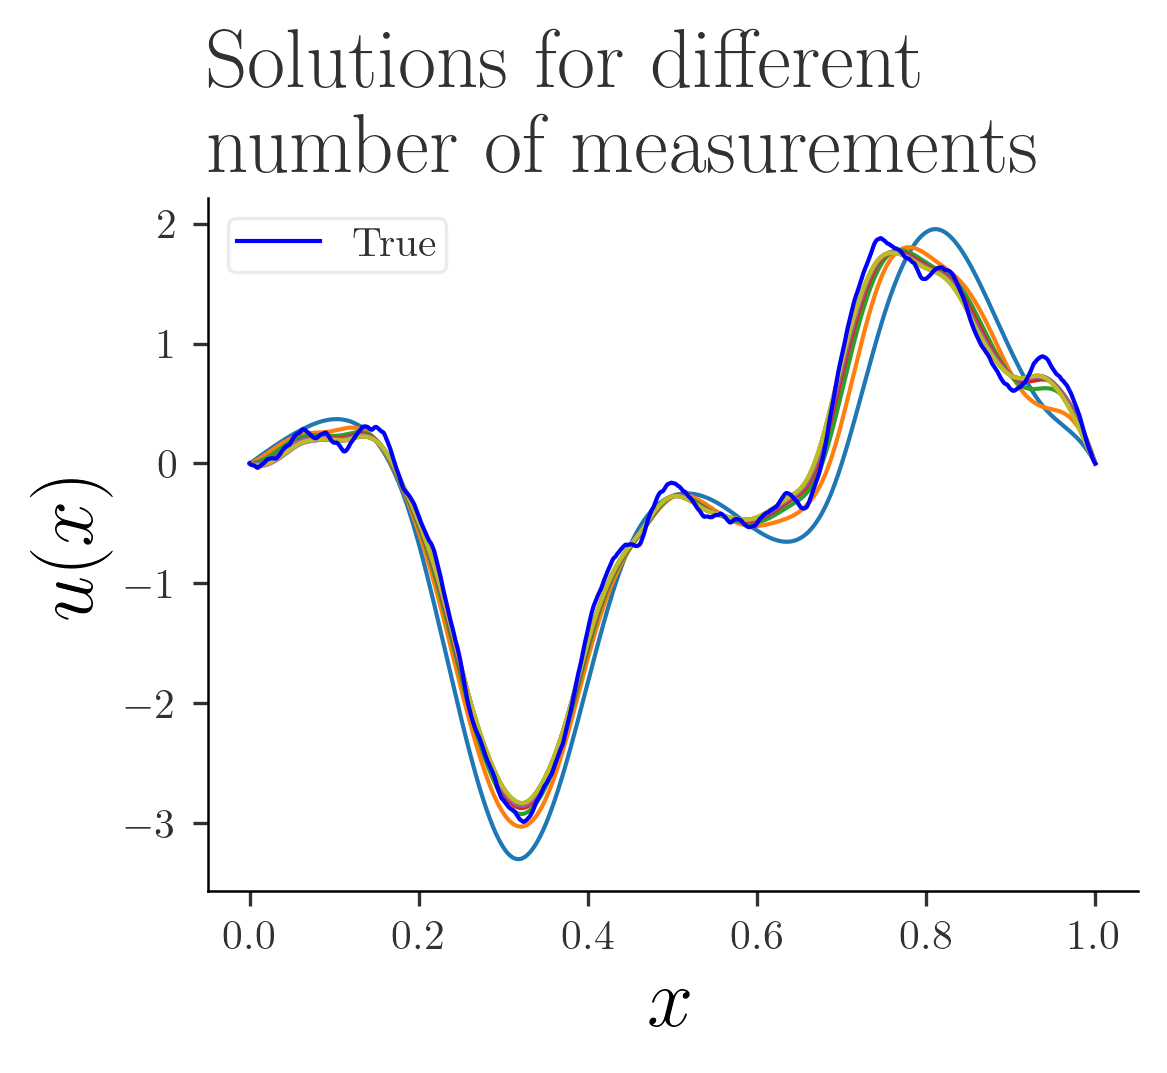

In [306]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [307]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.209


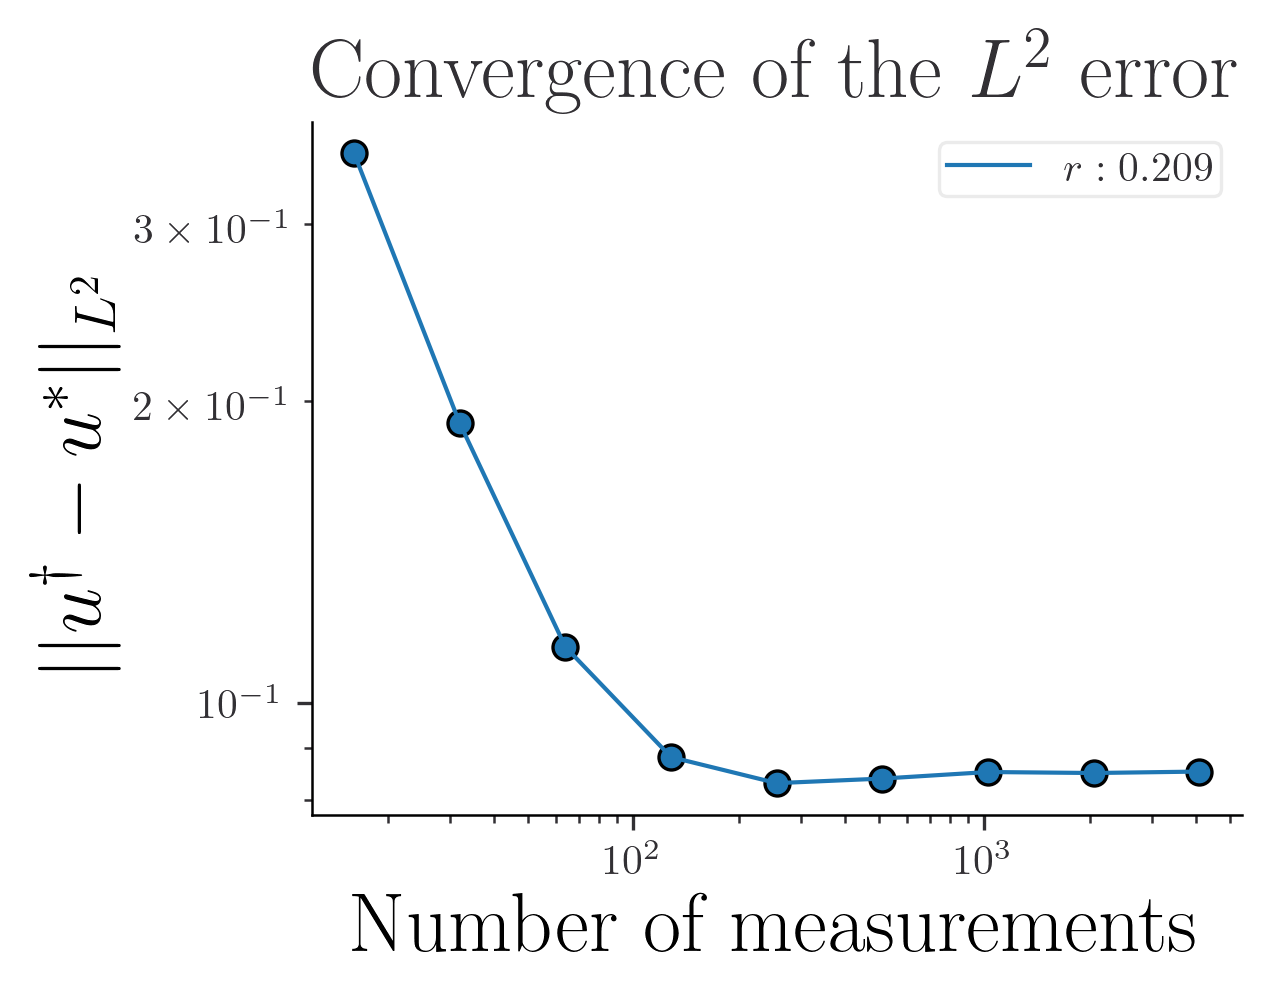

In [308]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


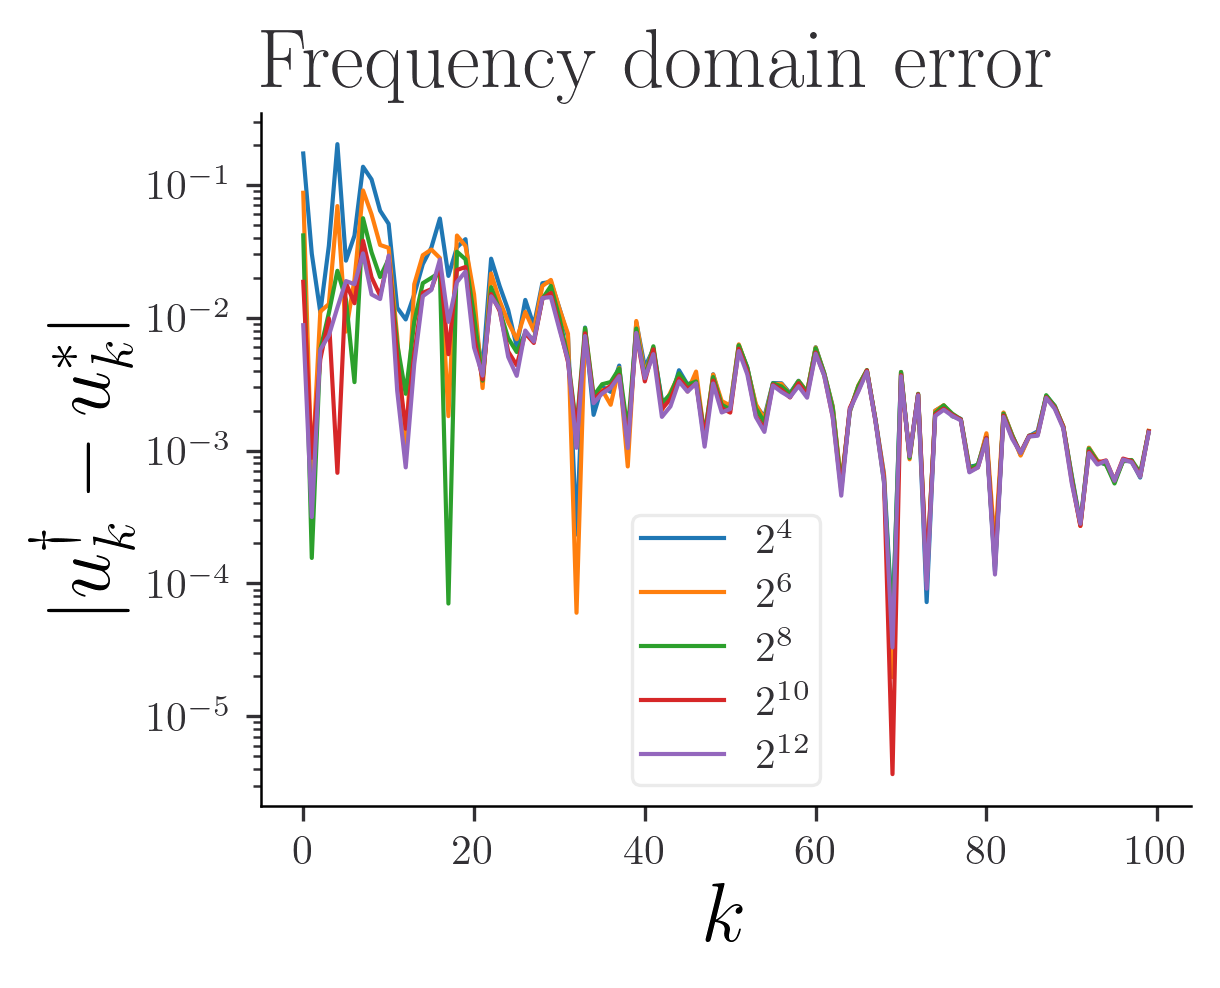

In [309]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


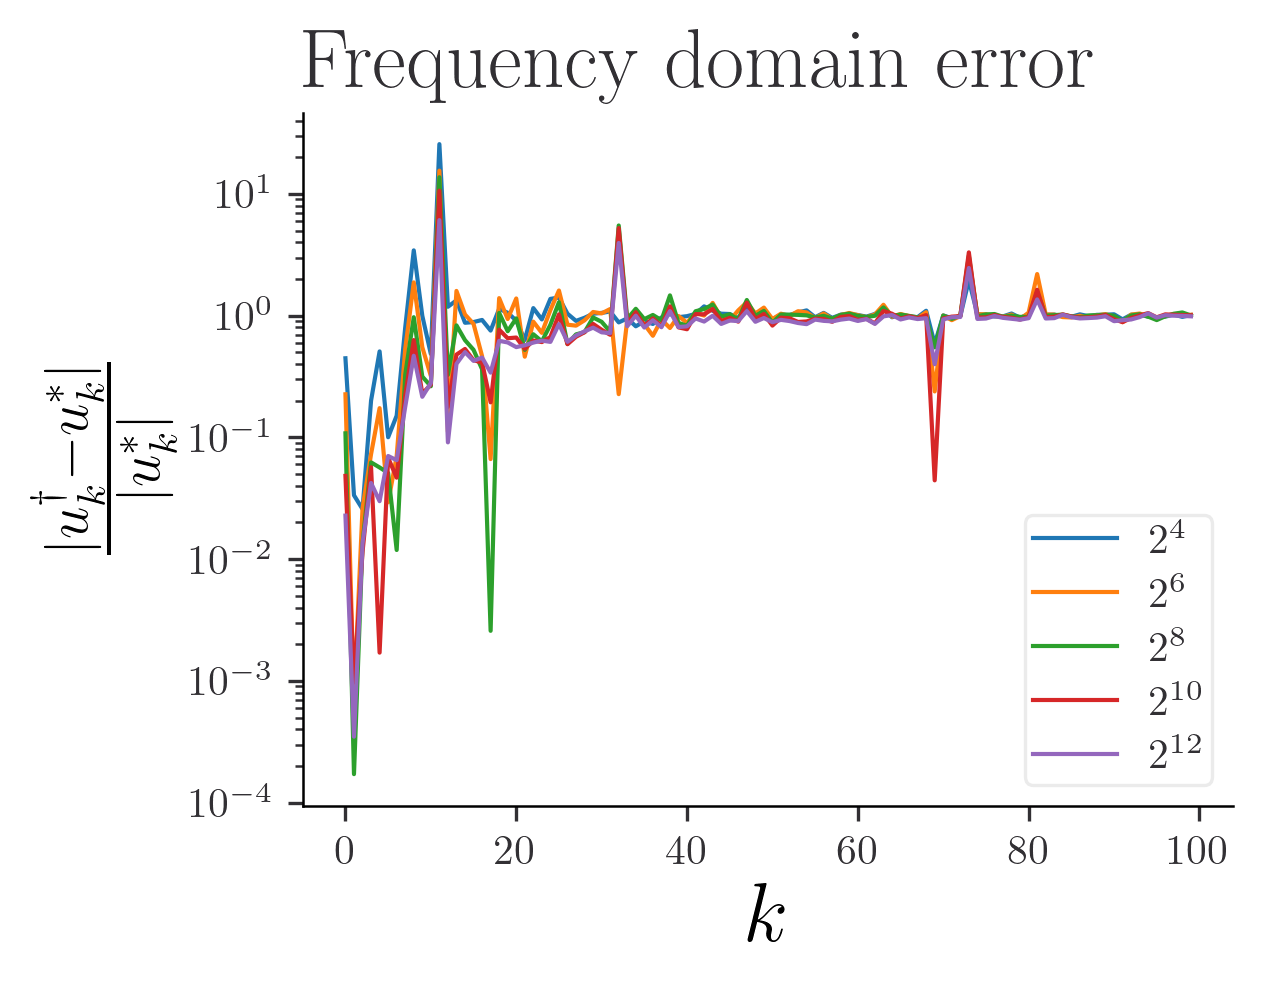

In [310]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Using the $H^{-1}$ norm

We recall that 

$$
|| \xi||^2_{H^{-1}} = \sum_{j=1}^\infty \xi_j^2 \lambda_j^{-1} \propto \sum_{j=1}^\infty \xi_j^2 j^{-2}
$$

In [90]:
jnp.arange(1, n_meas)**2*1e-12

Array([1.0000000e-12, 4.0000000e-12, 9.0000000e-12, ..., 1.6752649e-05,
       1.6760836e-05, 1.6769025e-05], dtype=float64, weak_type=True)

In [91]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-12


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)[1:, 1:]
    theta_12_sine = vmap_dst(theta_12)[:, 1:]
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    # Solve the linear system
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.arange(1, n_meas+1)**2])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # 

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))[:, 1:]
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Compute errors
    pred_transform = discrete_sine_transform(pred)[1:]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
    error.append(L2_error)
    error_rel.append(relative_L2_error)
    
    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:07,  1.09it/s]

32


 22%|██▏       | 2/9 [00:01<00:06,  1.03it/s]

64


 33%|███▎      | 3/9 [00:02<00:05,  1.07it/s]

128


 44%|████▍     | 4/9 [00:03<00:04,  1.04it/s]

256


 56%|█████▌    | 5/9 [00:04<00:03,  1.03it/s]

512


 67%|██████▋   | 6/9 [00:06<00:03,  1.07s/it]

1024


 78%|███████▊  | 7/9 [00:08<00:02,  1.46s/it]

2048


 89%|████████▉ | 8/9 [00:19<00:04,  4.59s/it]

4096


100%|██████████| 9/9 [00:55<00:00,  6.15s/it]


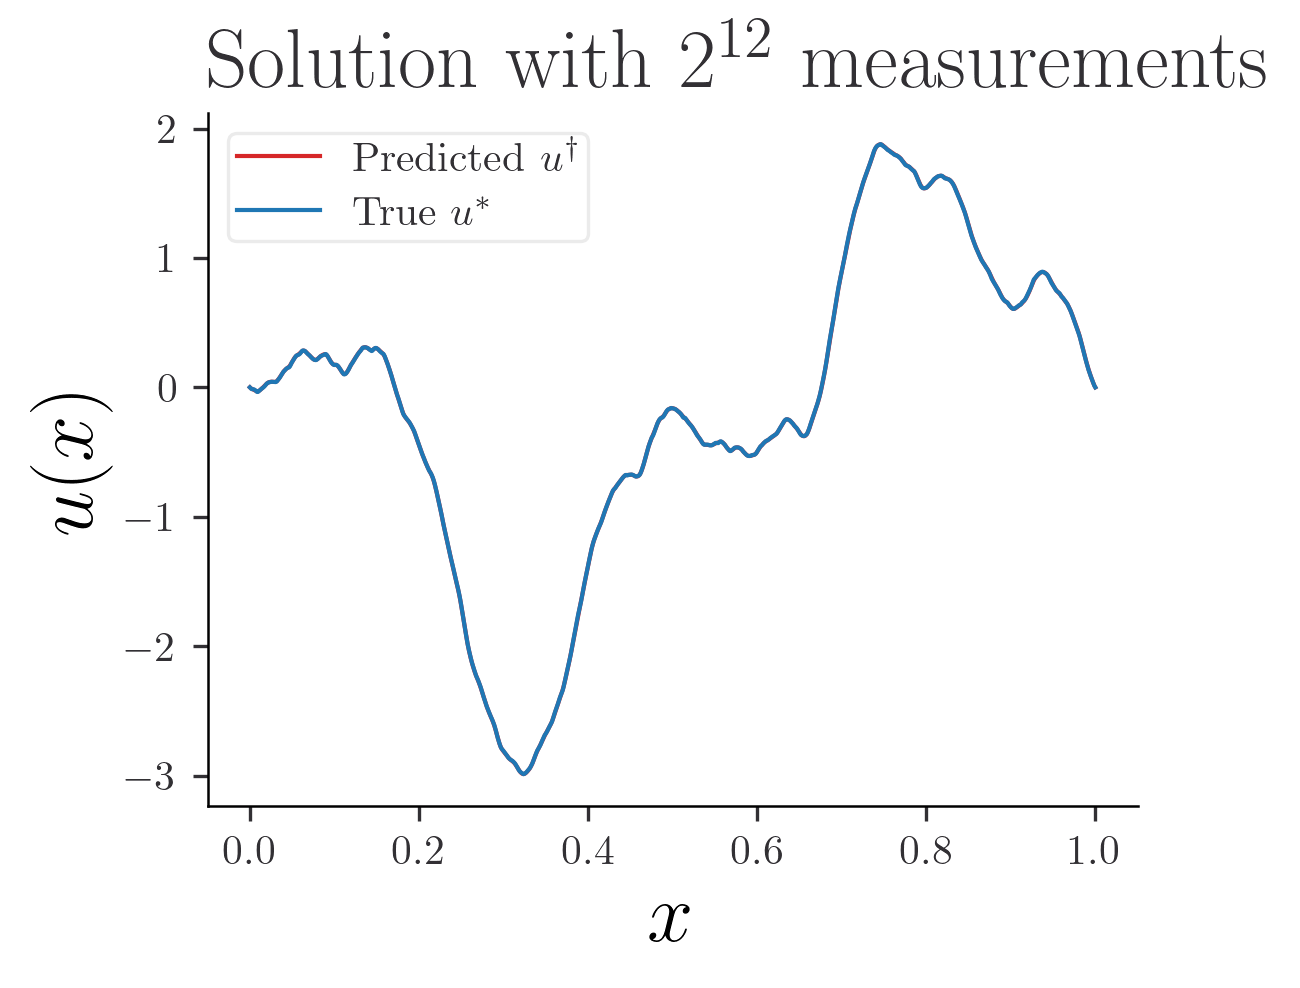

In [92]:
figure = plt.figure(figsize=(width, height))


plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


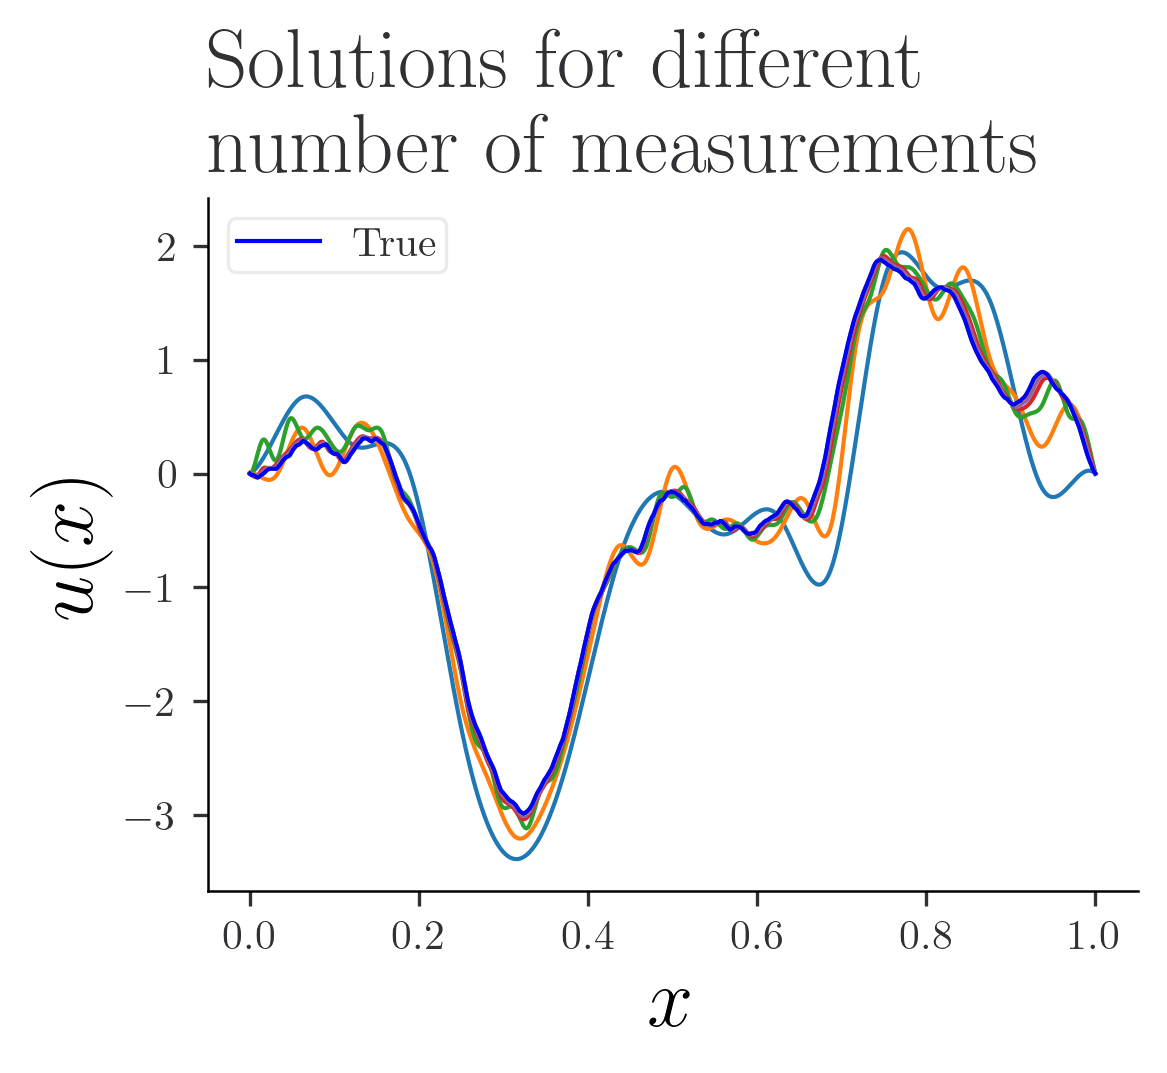

In [93]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [94]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.0130000000000001


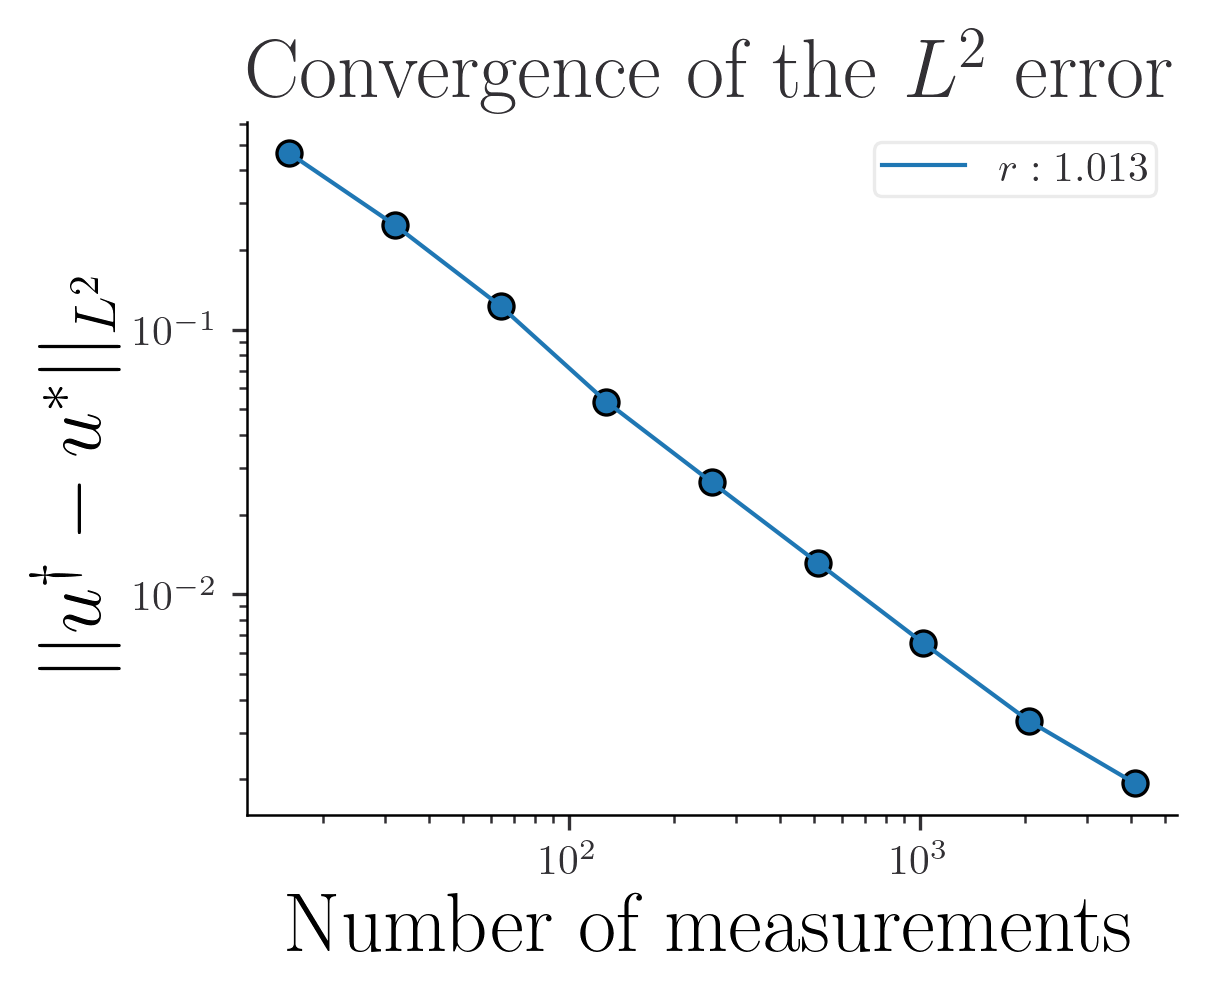

In [102]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


In [96]:
error[-1]

Array(0.00193248, dtype=float64)

In [97]:
error

Array([0.46449351, 0.2484208 , 0.12273212, 0.05343816, 0.02645899,
       0.01317217, 0.00653836, 0.0033197 , 0.00193248], dtype=float64)

In [98]:
2**meas_exp

Array([  16,   32,   64,  128,  256,  512, 1024, 2048, 4096], dtype=int64)

In [99]:
meas_exp

Array([ 4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

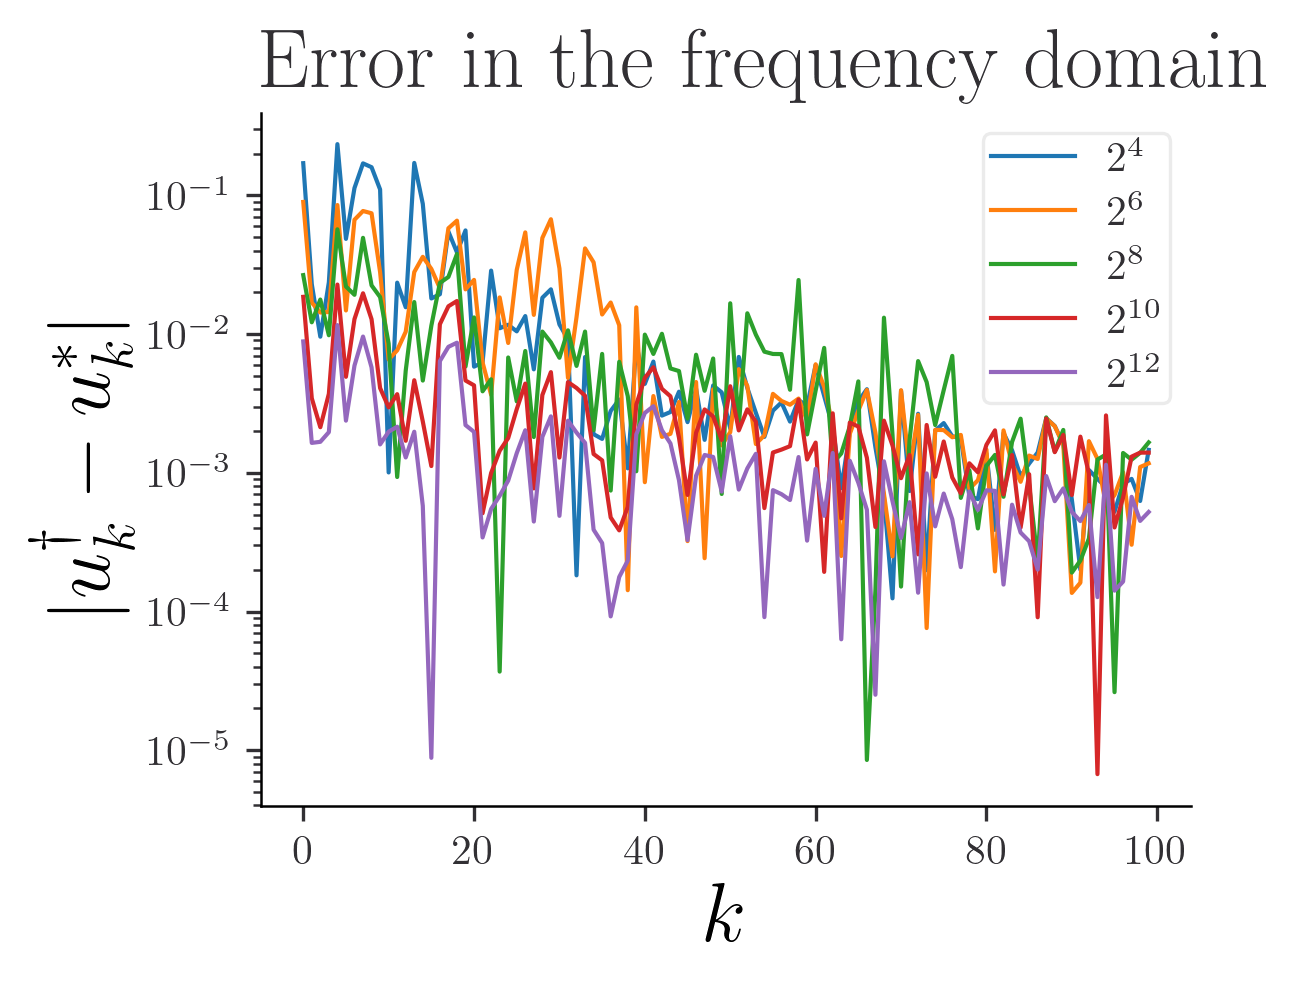

In [100]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Error in the frequency domain")
plt.show()


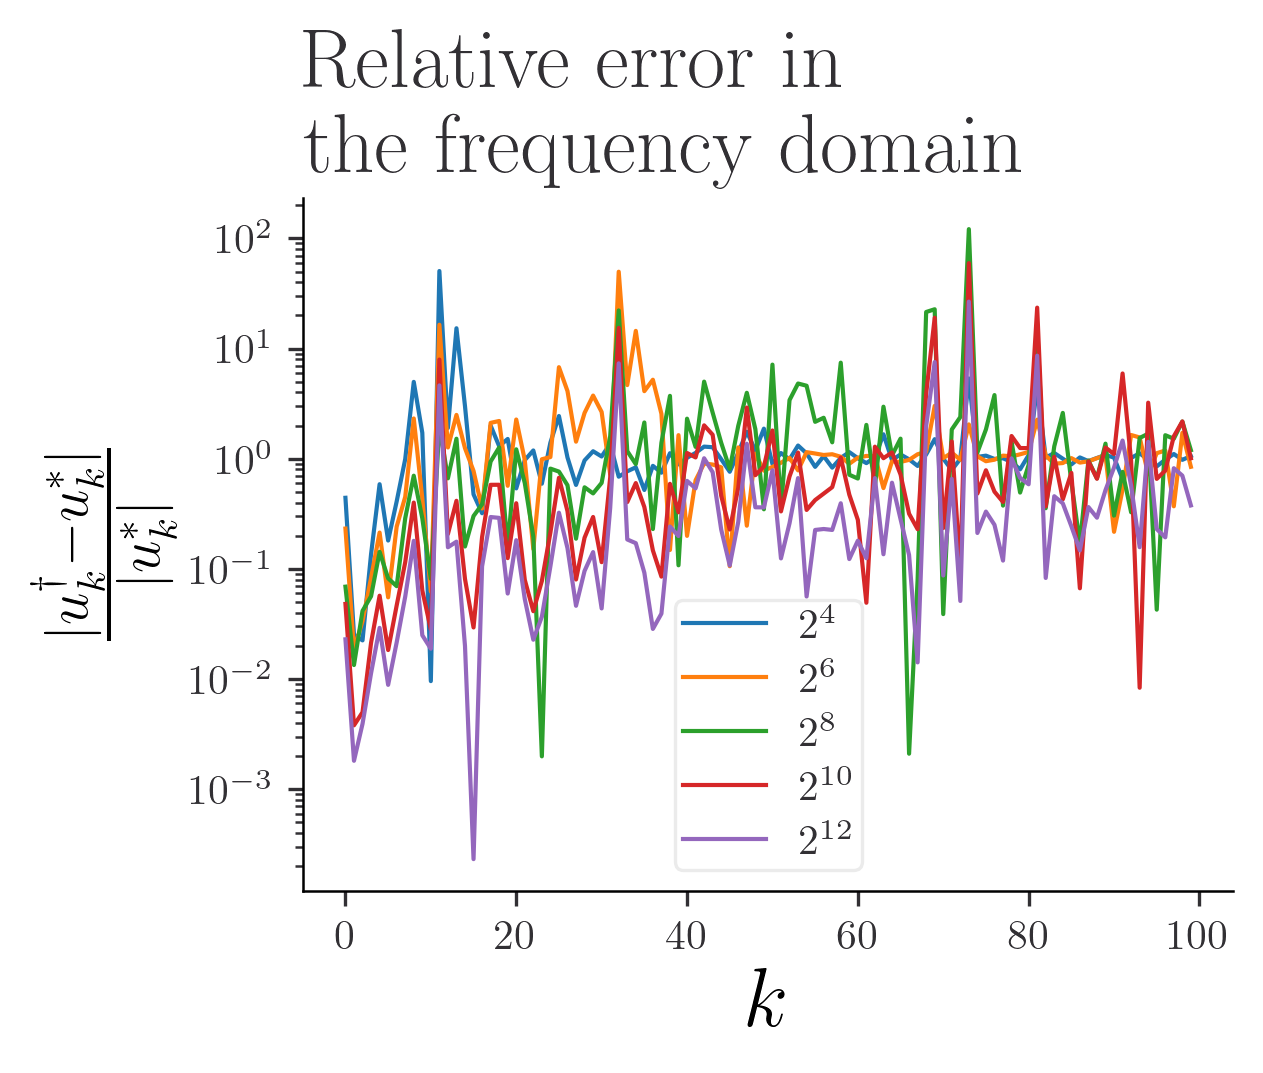

In [106]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title("Relative error in \n the frequency domain")
plt.show()

# A 2D example

In [ ]:
j,k= 1,5
m,n = 2,4
f = lambda x,y: jnp.cos(2*jnp.pi*(j*x + k*y)) + 4.12*jnp.sin(2*jnp.pi*(m*x + n*y))

In [ ]:
domain = jnp.array([0,1])

# 2d grid 
x = jnp.linspace(domain[0], domain[1], n_points)
y = jnp.linspace(domain[0], domain[1], n_points)
X, Y = jnp.meshgrid(x, y)

In [ ]:
values = f(X,Y)

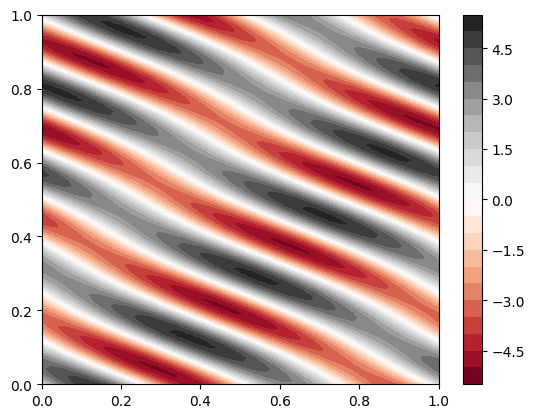

In [ ]:
# 2D plot
plt.contourf(X, Y, values, 20, cmap='RdGy')
plt.colorbar()

In [ ]:
alpha = fft.fft2(values)

In [ ]:
def get_cos_sin_coef_2d(alpha):
    n = alpha.shape[0]
    m = alpha.shape[1]
    c = alpha[0,0].real/(n*m)
    a = 2*alpha.real/(n*m)
    b = -2*alpha.imag/(n*m)
    return a, b, c


In [ ]:
a, b, c = get_cos_sin_coef_2d(alpha)

In [ ]:
def evaluate_real_domain(a,b):
    m,n = a.shape
    return fft.ifftn((a - 1j*b)*(m*n)/2).real

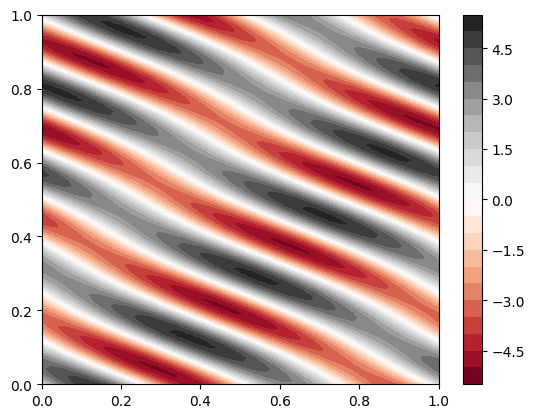

In [ ]:
f_eval = evaluate_real_domain(a,b)
# 2D plot
plt.contourf(X, Y, f_eval, 20, cmap='RdGy')
# colorbar
plt.colorbar()

In [ ]:
jnp.mean(jnp.abs(f_eval - values))

Array(6.91410817e-16, dtype=float64)

In [ ]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [ ]:
a_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)
b_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)  

a_test = a_test.at[k,j].set(1)
b_test = b_test.at[n,m].set(2)*4.12

In [ ]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [ ]:
f_eval_test = evaluate_real_domain(a_test,b_test)
jnp.mean(jnp.abs(f_eval_test - values))

Array(0.56350486, dtype=float64)

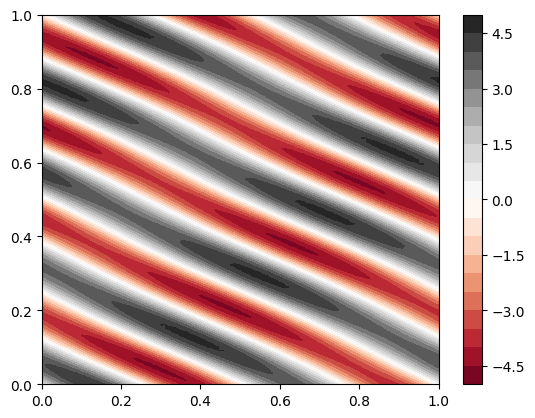

In [ ]:
plt.contourf(X, Y, f_eval_test, 20, cmap='RdGy')
# colorbar
plt.colorbar()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

